In [1]:
import typing
import json
import glob

import numpy
import pandas 

import scipy
import statsmodels
import statsmodels.stats
import statsmodels.stats.descriptivestats

import seaborn

In [2]:
MODELS: typing.List[str] = [
    "llama3.1-8b",
    "llama3.3-70b",
    "mistral-7b",
    "mistral-large-123b",
    "qwen2.5-7b",
    "qwen2.5-72b"
]

In [3]:
raw: typing.Dict[str, pandas.DataFrame]= {
    **{
        model: (
                pandas.concat(
                [
                    pandas.json_normalize(json.load(open(file))).assign(participant=n)
                    for n, file in enumerate(glob.glob(f"data/base/{model}/*.json", recursive=True))
                ],
            )
            .pivot(index="participant", columns="id", values="response")
            .apply(pandas.to_numeric)
        )
        for model in MODELS
    },
    "human_full": (
        pandas.read_csv("../../../data/humor_styles/survey.csv")
        .rename_axis(index="participant")
        .filter(like='Q', axis=1)
        .pipe(lambda _df: (
            _df
            .rename(columns={col: col[1:] for col in _df.columns})
        ))
        .replace(-1, None)
        .apply(pandas.to_numeric)
    ),
    "random": (
        pandas.DataFrame(numpy.random.randint(0,5, (1000, 32)), columns=range(1,33))
        .rename_axis(index="participant")
    )
}

raw.keys()

dict_keys(['llama3.1-8b', 'llama3.3-70b', 'mistral-7b', 'mistral-large-123b', 'qwen2.5-7b', 'qwen2.5-72b', 'human_full', 'random'])

In [4]:
for key, values in raw.items():
    values.to_csv(f"reports/raw.{key}.csv", index=False)

In [5]:
descriptive = pandas.concat({
    key: statsmodels.stats.descriptivestats.describe(values).T
    for key, values in raw.items()
})
descriptive

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


nobs  missing      mean   std_err  upper_ci  lower_ci  \
llama3.1-8b 1   1000.0     15.0  2.506599  0.039158  2.583348  2.429850   
            2   1000.0     15.0  2.254822  0.042601  2.338319  2.171325   
            3   1000.0     30.0  3.652577  0.038620  3.728271  3.576883   
            4   1000.0      5.0  2.976884  0.052253  3.079299  2.874470   
            5   1000.0     12.0  3.451417  0.050294  3.549992  3.352842   
...                ...      ...       ...       ...       ...       ...   
random      28  1000.0      0.0  1.985000  0.044618  2.072450  1.897550   
            29  1000.0      0.0  1.984000  0.044223  2.070676  1.897324   
            30  1000.0      0.0  1.964000  0.044257  2.050742  1.877258   
            31  1000.0      0.0  1.950000  0.043628  2.035509  1.864491   
            32  1000.0      0.0  1.966000  0.043529  2.051314  1.880686   

                     std  iqr  iqr_normal       mad  ...  median   1%   5%  \
llama3.1-8b 1   1.228972  1.0    0.741301  1.054083  ...     2.0  1.0  1.0   
            2   1.337027  2.0    1.482602  1.085787  ...     2.0  1.0  1.0   
            3   1.202817  1.0    0.741301  0.919885  ...     4.0  1.0  1.0   
            4   1.648262  4.0    2.965204  1.504534  ...     3.0  1.0  1.0   
            5   1.580872  3.0    2.223903  1.435616  ...     4.0  1.0  1.0   
...                  ...  ...         ...       ...  ...     ...  ...  ...   
random      28  1.410945  2.0    1.482602  1.192150  ...     2.0  0.0  0.0   
            29  1.398463  2.0    1.482602  1.194784  ...     2.0  0.0  0.0   
            30  1.399522  2.0    1.482602  1.192264  ...     2.0  0.0  0.0   
            31  1.379639  2.0    1.482602  1.169000  ...     2.0  0.0  0.0   
            32  1.376495  2.0    1.482602  1.164936  ...     2.0  0.0  0.0   

                10%  25%  50%  75%  90%  95%  99%  
llama3.1-8b 1   1.0  2.0  2.0  3.0  4.0  5.0  5.0  
            2   1.0  1.0  2.0  3.0  5.0  5.0  5.0  
            3   1.0  3.0  4.0  4.0  5.0  5.0  5.0  
            4   1.0  1.0  3.0  5.0  5.0  5.0  5.0  
            5   1.0  2.0  4.0  5.0  5.0  5.0  5.0  
...             ...  ...  ...  ...  ...  ...  ...  
random      28  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            29  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            30  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            31  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            32  0.0  1.0  2.0  3.0  4.0  4.0  4.0  

[256 rows x 31 columns]

In [6]:
raw["human_sampled"] = (
    pandas.DataFrame(numpy.stack([
        numpy.random.normal(row["mean"], row["std"], 1000).astype(int)
        for _, row in descriptive.loc["human_full"][["mean", "std"]].iterrows()
    ], axis=1), columns=range(1,33))
    .rename_axis(index="participant")
)

In [7]:
pandas.concat({
    (key_1, key_2): (
        pandas.Series(
            scipy
            .stats.f_oneway(
                values_1,
                values_2,
                nan_policy="omit"
            )
            .pvalue
            > 0.05,
            name="f_oneway_significant"
        )
        .value_counts()
    )
    for key_1, values_1 in raw.items()
    for key_2, values_2 in raw.items()
}).to_frame()

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


count
                            f_oneway_significant       
llama3.1-8b   llama3.1-8b   True                     22
                            False                    10
              llama3.3-70b  False                    30
                            True                      2
              mistral-7b    False                    26
...                                                 ...
human_sampled qwen2.5-72b   True                      1
              human_full    False                    32
              random        False                    30
                            True                      2
              human_sampled True                     32

[144 rows x 1 columns]

In [8]:
def calc_fingerprint(df: pandas.DataFrame) -> numpy.ndarray:
    corr_matrix = numpy.triu(df.corr("pearson").fillna(0.0).to_numpy())

    return corr_matrix[numpy.triu_indices_from(corr_matrix, k=1)]

def calc_similarity(df_1, df_2) -> float:
    x1 = calc_fingerprint(df_1)
    x2 = calc_fingerprint(df_2)
    
    return numpy.dot(x1, x2)/(numpy.linalg.norm(x1)*numpy.linalg.norm(x2))

In [18]:
sim = (
    pandas.concat({
        (key_1, key_2): pandas.Series(
            calc_similarity(values_1, values_2),
            name="similarity"
        )
        for key_1, values_1 in raw.items()
        for key_2, values_2 in raw.items()
    })
    .to_frame()
    .reset_index(level=[0, 1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    .reindex(
        columns=(idx := ["random", "human_sampled", "human_full", *MODELS]),
        index=idx
    )
    .where(lambda df: pandas.DataFrame(
        [[i > j for j in range(len(df.columns))] for i in range(len(df.index))],
        index=df.index,
        columns=df.columns
    ))
)

print(
    sim
    .style
    # .background_gradient(axis=None)
    .format(na_rep="", precision=3) 
    .format_index(escape="latex", axis=1)
    .format_index(escape="latex", axis=0)
    .map_index(
        lambda v: "rotatebox:{65}--rwrap--latex;", level=0, axis=1
    ) 
    .to_latex(convert_css=True, hrules=True, clines="skip-last;data") 
)

print({
    "mean": sim.stack().mean(),
    "std": sim.stack().std()
})

\begin{tabular}{lrrrrrrrrr}
\toprule
level_1 & \rotatebox{65}{random} & \rotatebox{65}{human\_sampled} & \rotatebox{65}{human\_full} & \rotatebox{65}{llama3.1-8b} & \rotatebox{65}{llama3.3-70b} & \rotatebox{65}{mistral-7b} & \rotatebox{65}{mistral-large-123b} & \rotatebox{65}{qwen2.5-7b} & \rotatebox{65}{qwen2.5-72b} \\
level_0 &  &  &  &  &  &  &  &  &  \\
\midrule
random &  &  &  &  &  &  &  &  &  \\
human\_sampled & 0.049 &  &  &  &  &  &  &  &  \\
human\_full & 0.021 & -0.075 &  &  &  &  &  &  &  \\
llama3.1-8b & 0.028 & -0.026 & -0.022 &  &  &  &  &  &  \\
llama3.3-70b & -0.032 & -0.089 & 0.006 & -0.028 &  &  &  &  &  \\
mistral-7b & -0.030 & 0.085 & 0.085 & -0.036 & -0.047 &  &  &  &  \\
mistral-large-123b & 0.006 & -0.022 & 0.130 & -0.047 & 0.054 & 0.044 &  &  &  \\
qwen2.5-7b & 0.031 & -0.032 & 0.164 & -0.027 & 0.085 & -0.020 & 0.070 &  &  \\
qwen2.5-72b & 0.077 & 0.001 & -0.068 & 0.082 & -0.020 & 0.040 & 0.053 & 0.034 &  \\
\bottomrule
\end{tabular}

{'mean': np.float64(0.0146

<Axes: xlabel='level_1', ylabel='level_0'>

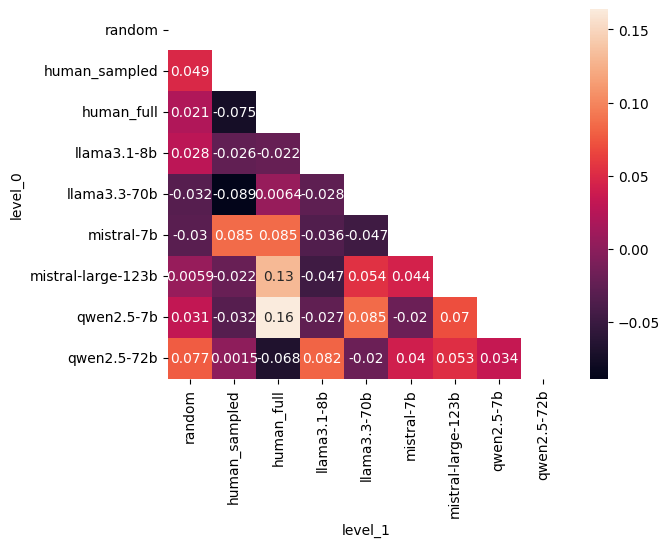

In [10]:
seaborn.heatmap(sim, annot=True, mask=numpy.triu(sim))

In [17]:
human_chunked = {
    f"{n:02d}": chunk
    for n, chunk in enumerate(numpy.array_split(raw["human_full"].sample(frac=1.0), 10), start=1)
}

sim = (
    pandas.concat({
        (key_1, key_2): pandas.Series(
            calc_similarity(values_1, values_2),
            name="similarity"
        )
        for key_1, values_1 in human_chunked.items()
        for key_2, values_2 in human_chunked.items()
    })
    .to_frame()
    .reset_index(level=[0,1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    #
    .where(lambda df: pandas.DataFrame(
        [[i > j for j in range(len(df.columns))] for i in range(len(df.index))],
        index=df.index,
        columns=df.columns
    ))
    
)

print(
    sim
    .style
    .format(na_rep="", precision=3) 
    .format_index(escape="latex", axis=1)
    .format_index(escape="latex", axis=0)
    .to_latex(convert_css=True, hrules=True, clines="skip-last;data") 
)

print({
    "mean": sim.stack().mean(),
    "std": sim.stack().std()
})

\begin{tabular}{lrrrrrrrrrr}
\toprule
level_1 & 01 & 02 & 03 & 04 & 05 & 06 & 07 & 08 & 09 & 10 \\
level_0 &  &  &  &  &  &  &  &  &  &  \\
\midrule
01 &  &  &  &  &  &  &  &  &  &  \\
02 & 0.775 &  &  &  &  &  &  &  &  &  \\
03 & 0.736 & 0.850 &  &  &  &  &  &  &  &  \\
04 & 0.772 & 0.852 & 0.841 &  &  &  &  &  &  &  \\
05 & 0.775 & 0.858 & 0.843 & 0.825 &  &  &  &  &  &  \\
06 & 0.759 & 0.788 & 0.804 & 0.809 & 0.819 &  &  &  &  &  \\
07 & 0.789 & 0.830 & 0.840 & 0.846 & 0.843 & 0.817 &  &  &  &  \\
08 & 0.789 & 0.844 & 0.843 & 0.859 & 0.859 & 0.829 & 0.847 &  &  &  \\
09 & 0.740 & 0.851 & 0.837 & 0.836 & 0.823 & 0.815 & 0.802 & 0.847 &  &  \\
10 & 0.744 & 0.839 & 0.840 & 0.865 & 0.851 & 0.813 & 0.844 & 0.844 & 0.844 &  \\
\bottomrule
\end{tabular}

{'mean': np.float64(0.8216810004714713), 'std': np.float64(0.03424382179538316)}


/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
